In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from sklearn import metrics
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cpu')

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance).

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [97]:
print("Started running car segmentation model.")
BATCH_SIZE = 64
ARRAYS_FOLDER = './arrays_preprocessed/'

black_5_doors_arrays = {}
orange_3_doors_arrays = {}
photo_arrays = {}

npy_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.endswith('.npy')]
for file in npy_files:
    file_path = os.path.join(ARRAYS_FOLDER, file)
    
    # Load the numpy array and normalize by dividing with the maximum value
    sample_tensor = torch.from_numpy(np.load(file_path)) / 255
    
    sample_tensor = sample_tensor.permute(2, 0, 1)  # Reshaping from HxWxC to CxHxW
    
    # Extract the image data and target values
    image_data = sample_tensor[0:3, :, :]  # First 3 channels are the image data
    target = sample_tensor[3:6, :, :]  # Last 3 channels contain the target value
    
    if file.startswith('black_5_doors'):
        black_5_doors_arrays[file] = {'image_data': image_data, 'target': target}       
    elif file.startswith('orange_3_doors'):
        orange_3_doors_arrays[file] = {'image_data': image_data, 'target': target}
    elif file.startswith('photo_'):
        photo_arrays[file] = {'image_data': image_data, 'target': target}
        
image_data_list = []
target_list = []
for data_dict in black_5_doors_arrays:
    image_data = black_5_doors_arrays[data_dict]['image_data']
    target_data = black_5_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in orange_3_doors_arrays:
    image_data = orange_3_doors_arrays[data_dict]['image_data']
    target_data = orange_3_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in photo_arrays:
    image_data = photo_arrays[data_dict]['image_data']
    target_data = photo_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)


images_tensor = torch.stack(image_data_list, dim=0)
masks_tensor = torch.stack(target_list, dim=0)
dataset = TensorDataset(images_tensor, masks_tensor)

DATASET_LENGTH = len(dataset)
train_size = math.floor(DATASET_LENGTH * 0.8)
val_size = math.floor(DATASET_LENGTH * 0.1)
test_size = DATASET_LENGTH - train_size - val_size

generator_seed = torch.Generator().manual_seed(0)
train_set, temp_set = random_split(dataset, [train_size, val_size + test_size], generator=generator_seed)
val_set, test_set = random_split(temp_set, [val_size, test_size], generator=generator_seed)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)  # x1 and x2 need to have the same number of rows, I think
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # the CrossEntropyLoss automatically wraps this in a LogSoftmax, that's why we don't do it here
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.inc = (ConvBlock(3, 64, 64)) 
        self.down1 = (Down(64, 128)) 
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, 3))

    def forward(self, x):
        x1 = self.inc(x)  # x1 HxW: 256x256
        x2 = self.down1(x1)  # x2 HxW: 128x128
        x3 = self.down2(x2)  # x3 HxW: 64x64
        x4 = self.down3(x3)  # x4 HxW: 32x32
        x5 = self.down4(x4)  # x5 HxW: 16x16
        x = self.up1(x5, x4)  # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# TODO: maybe here we want to use the dice coefficient instead? (torchmetrics.Dice ?)
# TODO: this needs a fix
def accuracy(outputs, targets):
    # Assuming binary segmentation
    # preds = torch.softmax(outputs)
    # preds = (preds == preds.max()).float()  # Convert to binary predictions
    # correct = (preds == targets).sum().item()
    # total = targets.numel()
    # acc = correct / total
    return 1


def save_model(model, optimizer, save_path):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')


def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model loaded from {load_path}')
    return model, optimizer


def evaluate_val_test_set(model, device, loss_fn, set_length, loader):
    with torch.no_grad():
        model.eval()
        set_loss = 0
        set_acc = 0
        for inputs, masks in loader:
            inputs, masks = inputs.to(device), masks.to(device)
            output = model(inputs)
            set_loss += loss_fn(output, masks).item()

            batch_acc = accuracy(output, masks.to(device))
            set_acc += batch_acc

        set_acc /= len(loader)
        set_loss /= math.ceil(set_length / BATCH_SIZE)
        return set_loss, set_acc


def train_model(model, epochs, optimizer, loss_fn, save_path):
    if not torch.cuda.is_available():
        print("CUDA NOT AVAILABLE!!!!")
    else:
        print("CUDA WORKING!!!")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_steps = math.ceil(len(train_set) / BATCH_SIZE)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_acc = 0
        model.train()
        
        for step, (inputs, masks) in enumerate(train_loader, 1):  # Start counting steps from 1
            # print(f"Epoch: {epoch}, step: {step} out of {train_steps}.")
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            batch_loss = loss_fn(output, masks)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
            
            batch_acc = accuracy(output, masks)
            epoch_acc += batch_acc
        
        epoch_acc /= train_steps
        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss / train_steps)

        val_loss, val_acc = evaluate_val_test_set(model, device, loss_fn, len(val_set), val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch train loss: {train_losses[-1]}, train accuracy: {train_accuracies[-1]}")
        print(f"Epoch validation loss: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}")

    if save_path is not None:
        save_model(model, optimizer, save_path)

    test_loss, test_acc = evaluate_val_test_set(model, device, loss_fn, len(test_set), test_loader)
    print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

Started running car segmentation model.


Model loaded from model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


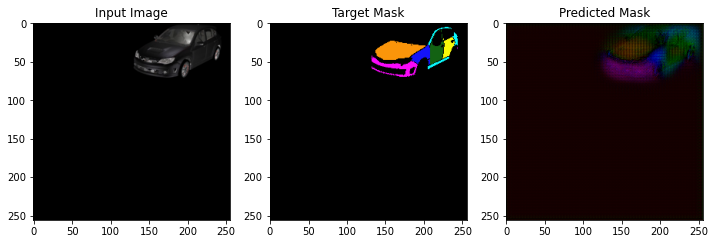

In [115]:
# Load the trained model
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, load_path)

# Choose an example from the test set
example_index = 12
example_input, example_target = test_set[example_index]

# Move the input to the appropriate device (CPU or GPU)
example_input = example_input.to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Make a prediction
with torch.no_grad():
    prediction = loaded_model(example_input.unsqueeze(0))

# Post-process the prediction if needed (e.g., convert to probabilities)
predicted_mask = (prediction*255).squeeze()

# Visualize the input, target, and predicted mask
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(example_input.permute(1, 2, 0).cpu().numpy())
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(example_target.permute(1, 2, 0).cpu().numpy())
plt.title('Target Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.permute(1, 2, 0).cpu().numpy() / 1000)
plt.title('Predicted Mask')

plt.show()


Model loaded from model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(920.8004)


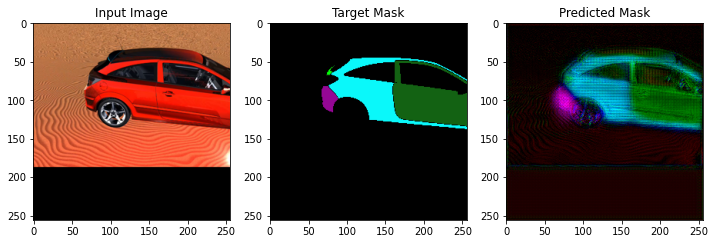

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(877.9097)


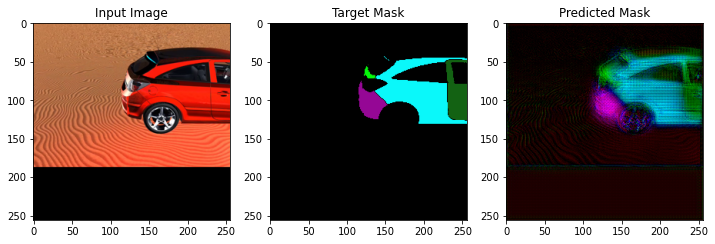

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(571.6297)


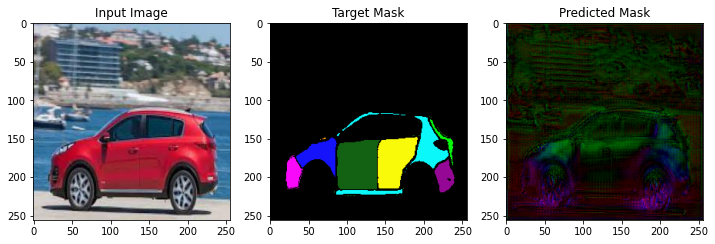

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1220.5675)


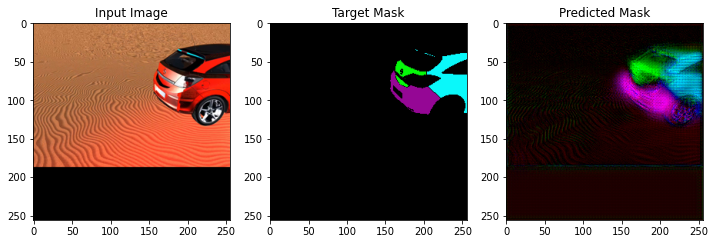

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(914.3743)


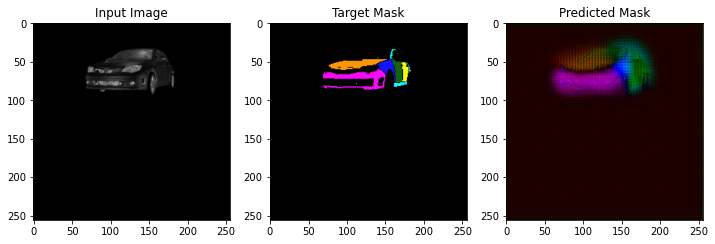

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1133.4408)


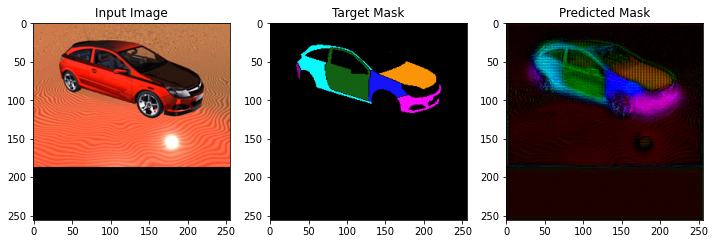

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(724.9823)


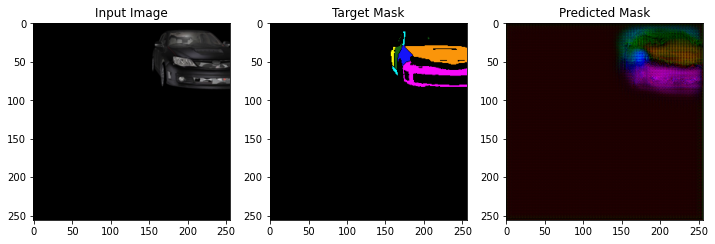

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1197.1476)


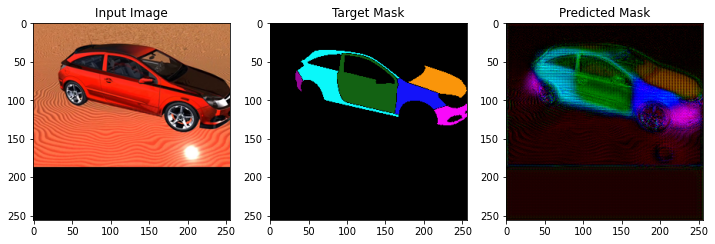

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1142.2450)


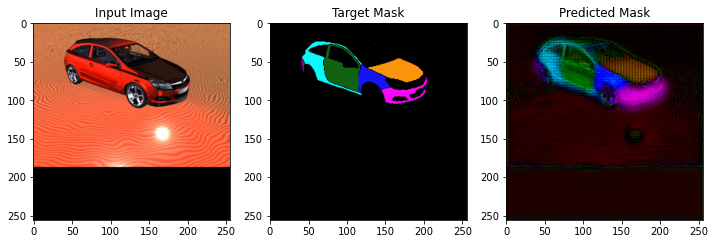

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1127.1138)


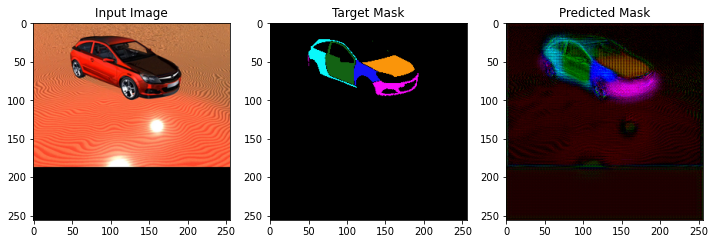

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(803.3407)


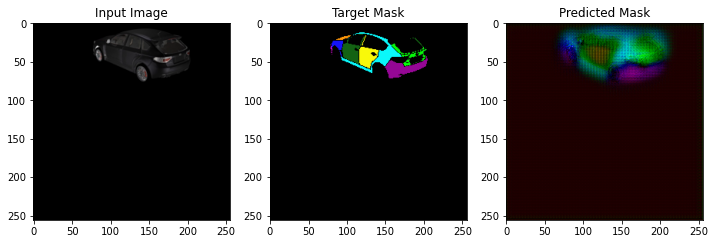

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1011.6887)


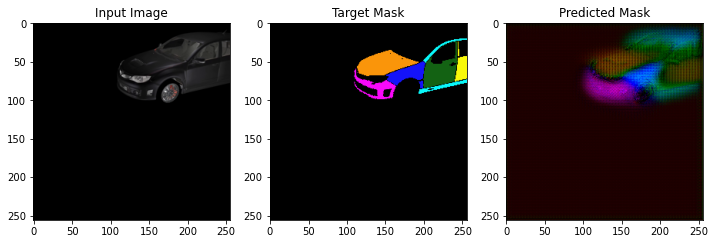

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(717.4087)


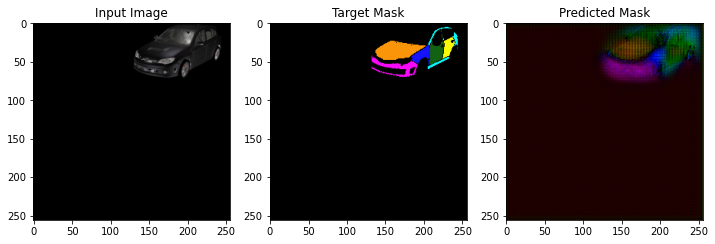

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(644.1006)


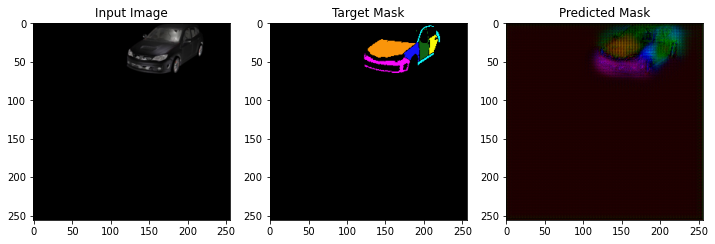

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(521.3714)


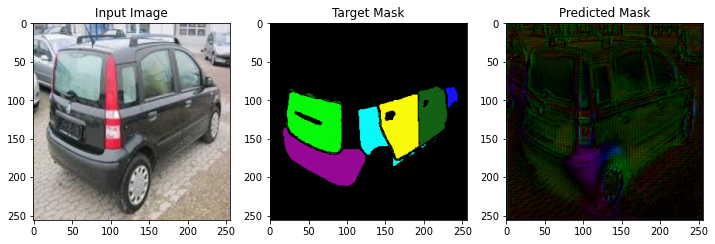

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(689.6700)


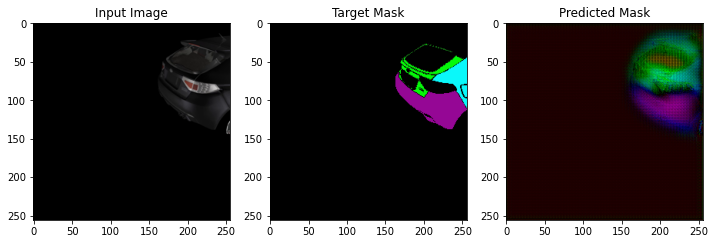

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(818.7507)


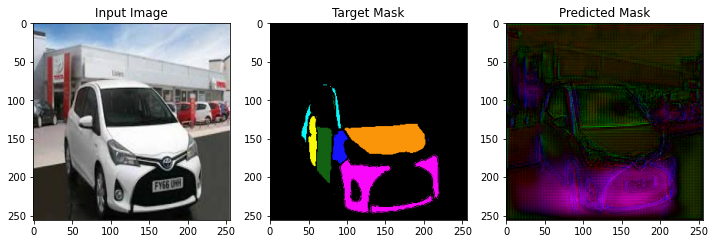

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1216.1431)


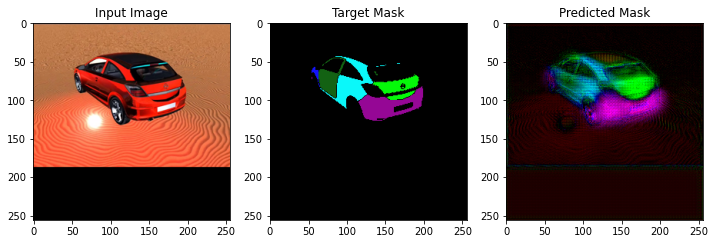

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(926.4330)


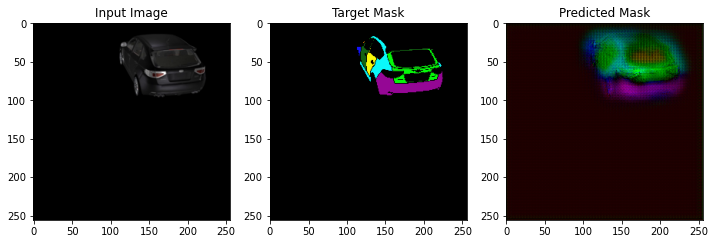

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(856.6318)


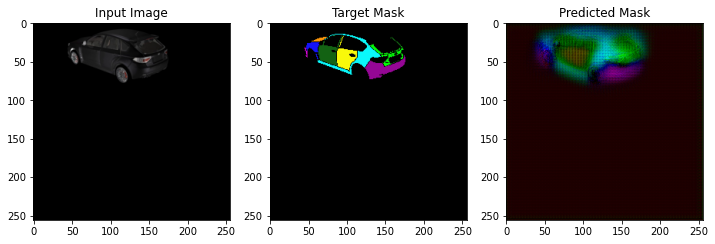

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(850.8644)


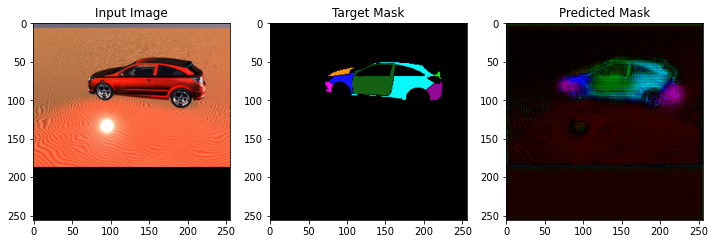

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1154.0778)


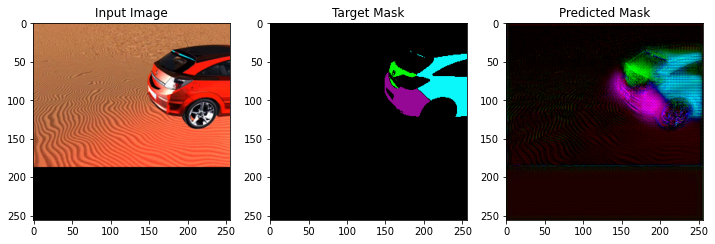

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1096.2014)


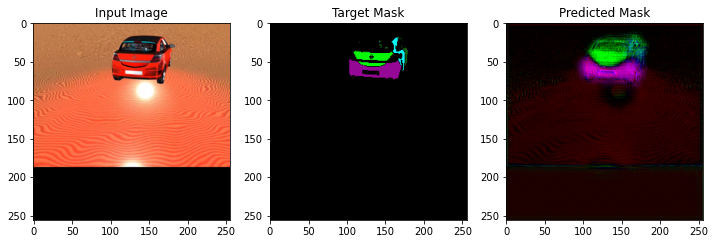

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(889.8203)


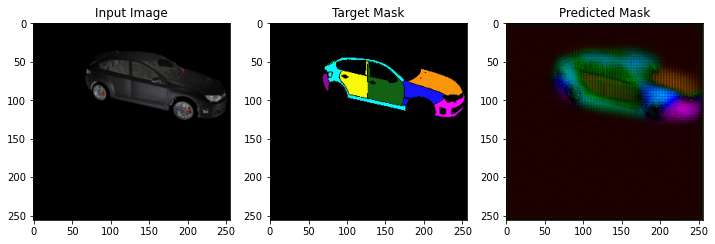

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(741.5902)


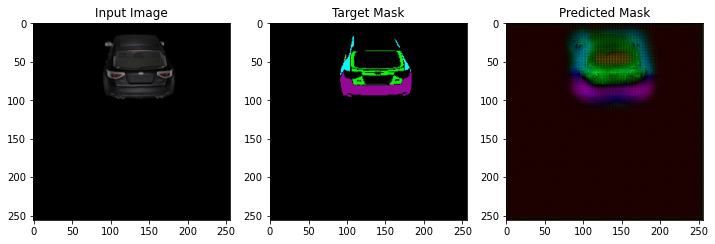

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1066.5498)


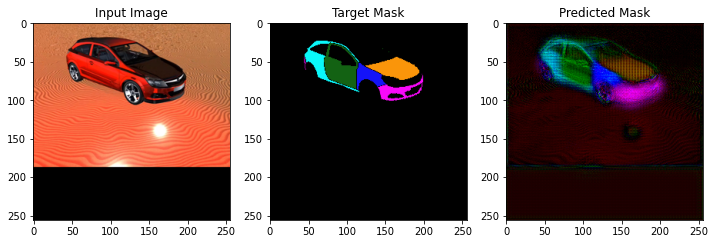

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(939.8652)


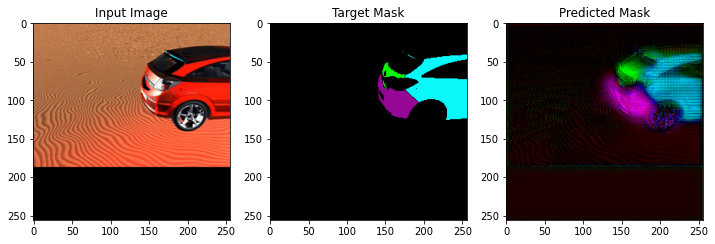

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(917.0691)


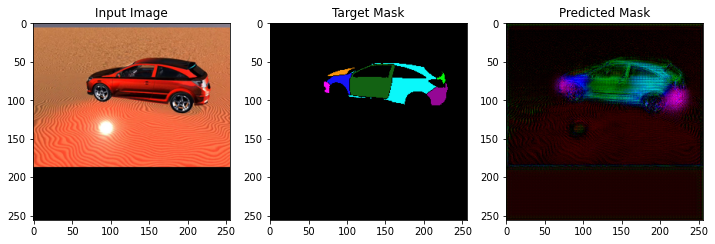

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1126.6135)


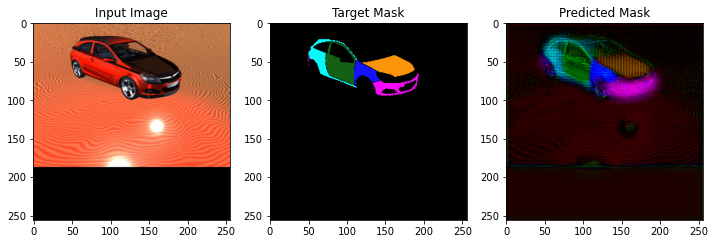

In [118]:
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, load_path)

loaded_model.eval()
step = 0
with torch.no_grad():
    for input_image, target in test_set:
        step += 1
        if step == 30:
            break
        input_image = input_image.to(device)
        prediction = loaded_model(input_image.unsqueeze(0))
        prediction = prediction.squeeze() * 255
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(target.cpu().permute(1, 2, 0).numpy())
        plt.title('Target Mask')

        print(prediction.max()) # TODO: why is the output max pixel value so large (~1000)
        plt.subplot(1, 3, 3)
        plt.imshow(prediction.cpu().permute(1, 2, 0).numpy() / 700)
        plt.title('Predicted Mask')

        plt.show()

tensor([  0,   5,  10,  19,  20, 149, 249, 250], dtype=torch.uint8)


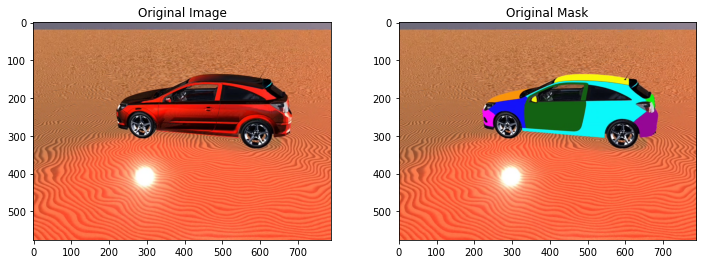

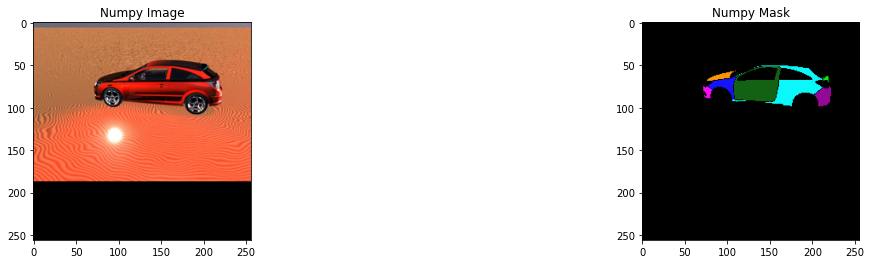

In [93]:
IMAGES_FOLDER = './carseg_data/images/'
ARRAYS_FOLDER = './arrays_preprocessed/'
BLACK_CAR_FOLDER = 'black_5_doors'
ORANGE_CAR_FOLDER = 'orange_3_doors'
REAL_CAR_FOLDER = 'photo'
SEGMENTATION_FOLDER = '/with_segmentation/'
NO_SEGMENTATION_FOLDER = '/no_segmentation/'

CAR_FOLDER = ORANGE_CAR_FOLDER
IMAGE_INDEX = '0050' # good indexes orange: 0050, 0250, 1050

image_original = torchvision.io.read_image(IMAGES_FOLDER + CAR_FOLDER + NO_SEGMENTATION_FOLDER + IMAGE_INDEX + ".png")
image_segmented = torchvision.io.read_image(IMAGES_FOLDER + CAR_FOLDER + SEGMENTATION_FOLDER + IMAGE_INDEX + ".png")

npy_image = np.load(ARRAYS_FOLDER + CAR_FOLDER + "_" + IMAGE_INDEX + '.npy')
print(torch.from_numpy(npy_image[:,:,3]).unique())
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_original.permute(1, 2, 0))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image_segmented.permute(1, 2, 0))
plt.title('Original Mask')

plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.imshow(npy_image[:, :, 0:3])
plt.title('Numpy Image')

plt.subplot(1, 2, 2)
plt.imshow(npy_image[:, :, 3:6])
plt.title('Numpy Mask')

plt.show()

### Segmentation class mappings (open cell to see better)

"color",        "description",          "class value",  "color values"
"orange",       "hood",                 10              (250, 149, 10)
"dark green",   "front door",           20              (19, 98, 19)
"yellow",       "rear door",            30              (249, 249, 10)
"cyan",         "frame",                40              (10, 248, 250)
"purple",       "rear quater panel",    50              (149, 7, 149)
"light green",  "trunk lid",            60              (5, 249, 9)
"blue",         "fender",               70              (20, 19, 249)
"pink",         "bumper",               80              (249, 9, 250)
"no color",     "rest of car",          90              NA

In [56]:
r_map = {0:0, 10: 250, 20: 19, 30: 249, 40: 10, 50: 149, 60: 5, 70: 20, 80: 249, 90: 0}
g_map = {0:0, 10: 149, 20: 98, 30: 249, 40: 248, 50: 7, 60: 249, 70: 19, 80: 9, 90: 0}
b_map = {0:0, 10: 10, 20: 19, 30: 10, 40: 250, 50: 149, 60: 9, 70: 249, 80: 250, 90: 0}

def map_r_pixel(current_pixel):
    return r_map[current_pixel]

def map_g_pixel(current_pixel):
    return g_map[current_pixel]

def map_b_pixel(current_pixel):
    return b_map[current_pixel]


map_r_pixel_vec = np.vectorize(map_r_pixel, otypes=['uint8'])
map_g_pixel_vec = np.vectorize(map_g_pixel, otypes=['uint8'])
map_b_pixel_vec = np.vectorize(map_b_pixel, otypes=['uint8'])

def map_npy_mask(original_mask):
    mapped_r = map_r_pixel_vec(original_mask)
    mapped_g = map_g_pixel_vec(original_mask)
    mapped_b = map_b_pixel_vec(original_mask)
    output = np.stack([mapped_r, mapped_g, mapped_b], axis=2)
    return output

In [85]:
black_5_doors_arrays = {}
orange_3_doors_arrays = {}
photo_arrays = {}
npy_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.endswith('.npy')]

# Categorize the arrays based on the file names
step = 0
for file in npy_files:
    step += 1
    if step % 100 == 0:
        print(step)
    
    file_path = os.path.join(ARRAYS_FOLDER, file)
    
    # Load the numpy array and normalize by dividing with the maximum value
#     sample_tensor = torch.from_numpy(np.load(file_path))
    sample_tensor = np.load(file_path)
#     sample_tensor = sample_tensor.permute(2, 0, 1)  # Reshaping from HxWxC to CxHxW
    
    # Extract the image data and target values
#     image_data = sample_tensor[0:3, :, :]  / 255 # First 3 channels are the image data
#     target = map_npy_mask(sample_tensor[3, :, :]) / 255  # Fourth channel contains target values
    image_data = sample_tensor[:, :, 0:3] # First 3 channels are the image data
    target = map_npy_mask(sample_tensor[:, :, 3])  # Fourth channel contains target values
#     print(image_data.shape, target.shape)
#     print(np.concatenate([image_data, target], axis=-1).shape)
    np.save("./arrays_preprocessed/" + file, np.concatenate([image_data, target], axis=-1))
    
#     if file.startswith('black_5_doors'):
#         black_5_doors_arrays[file] = {'image_data': image_data, 'target': target}       
#     elif file.startswith('orange_3_doors'):
#         orange_3_doors_arrays[file] = {'image_data': image_data, 'target': target}
#     elif file.startswith('photo_'):
#         photo_arrays[file] = {'image_data': image_data, 'target': target}

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


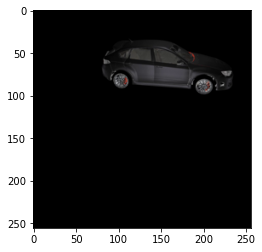

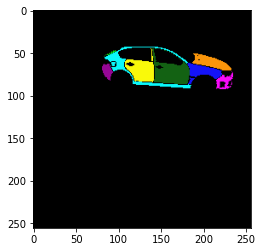

In [84]:
# Original time: 4-5 sec
# New time:
SAMPLE_FILE = 'black_5_doors_0001.npy'

sample_tensor = torch.from_numpy(np.load("./arrays_preprocessed/" + SAMPLE_FILE)) / 255
sample_tensor = sample_tensor.permute(2, 0, 1)  # Reshaping from HxWxC to CxHxW
    
image_data = sample_tensor[0:3, :, :]  # First 3 channels are the image data
target = sample_tensor[3:6, :, :]  # Fourth channel contains target values

print(image_data.shape, target.shape)

plt.imshow(image_data.permute(1, 2, 0))
plt.show()

plt.imshow(target.permute(1, 2, 0))
plt.show()

In [19]:
# model.save('trained_model.h5')

In [20]:
# Run the output on the test set

In [21]:
# Try pretrained models: MobileNetV2, ResNet101